# Benchmarking Models on the LIMIT Dataset

## Standard benchmark datasets vs LIMIT

In the following we compare the complexity of the LIMIT and LIMIT-small datasets with some widly used MTEB standard datasets:

- [NQ](https://huggingface.co/datasets/mteb/nq)
- [HotPotQA](https://huggingface.co/datasets/mteb/hotpotqa)
- [SciFact](https://huggingface.co/datasets/mteb/scifact)
- [FollowIR Core17](https://huggingface.co/datasets/mteb/Core17InstructionRetrieval)

We consider the datasets as query - query $G = (V, E)$ graphs: for each query correspond a single node, and the nodes are connected if and only if their queries have a common relevant document.
We measure the tipical **graph density** as
$$
    \rho = \frac{|E|}{\frac{|V|(|V| - 1)}{2}} = \frac{2|E|}{|V|(|V| - 1)}.
$$
Beside the density the global similarity of the queries is measured with the **average query strength**
$$
    \bar{s} = \frac{1}{|V|}\sum_{i \in V} s_i,
$$
where the strength of the $i$'th query is defined as the sum of the weights of the neighboring nodes
$$
    s_i = \sum_{j \in N(i)} w_{ij}, \quad \forall i.
$$

The weights of the edges are defined as the Jaccard-similarity of the queries,
$$
    w_{ij} := \frac{|q_i \cap q_j|}{|q_i \cup q_j|}, \quad \forall i,j.
$$

In [ ]:
import pandas as pd
from itertools import combinations

def query_graph_metrics(qrels: pd.DataFrame, top_k: int = 2) -> tuple[float, float]:
    """Computes graph-based metrics from query-document relevance data.

    Args:
        qrels (pd.DataFrame): Relevance judgments mapping queries to documents.
        top_k (int, optional): Number of top documents per query to consider.
            Defaults to 2.

    Returns:
        tuple[float]: A tuple containing the graph density and the average query strength.
    """
    
    # Get relevant documents per query
    relevant_df = qrels[qrels['score'] > 0]
    query_to_docs = relevant_df.groupby('query-id')['corpus-id'].apply(set).to_dict()
    
    query_ids = list(query_to_docs.keys())
    vertex_count = len(query_ids)
    
    strength_of_query = {
        q_id: 0
        for q_id in query_ids
    }
    
    # Add edges between queries that share relevant documents
    edge_count = 0
    for q1_id, q2_id in combinations(query_ids, top_k):
        docs1 = query_to_docs[q1_id]
        docs2 = query_to_docs[q2_id]
        intersection = len(docs1 & docs2)
        
        if intersection > 0:
            # Jaccard-similarity
            union = len(docs1 | docs2)
            jaccard_score = intersection / union if union > 0 else 0
            if jaccard_score > 0:
                strength_of_query[q1_id] += jaccard_score
                strength_of_query[q2_id] += jaccard_score
                edge_count += 1
    
    # Graph density
    density = 2 * edge_count / (vertex_count * (vertex_count - 1)) if vertex_count > 0 else 0
    
    # Average edge weight (query similarity)
    if edge_count > 0:
        strengths = strength_of_query.values()
        avg_strength = sum(strengths) / vertex_count if strengths else 0
    else:
        avg_strength = 0
    
    return density, avg_strength

In [2]:
from datasets import load_dataset

def query_graph_metrics_for(dataset_name: str, top_k: int = 2) -> tuple[float]:
    try:
        qrels = load_dataset(dataset_name, "default", split="test").to_pandas()
    except ValueError:
        qrels = load_dataset(dataset_name, "qrels", split="test").to_pandas()
        
    return query_graph_metrics(qrels, top_k)

In [ ]:
mteb_datasets = [
    "mteb/nq",
    "mteb/hotpotqa",
    "mteb/scifact",
    "mteb/Core17InstructionRetrieval",
    "orionweller/LIMIT",
]

graph_metrics = [
    query_graph_metrics_for(dataset)
    for dataset in mteb_datasets
]

In [6]:
import pandas as pd

df_results = pd.DataFrame({
    "dataset": [dataset.split("/")[-1] for dataset in mteb_datasets],
    "density": [d for d, s in graph_metrics],
    "strength": [s for d, s in graph_metrics]
})

In [7]:
df_results

,dataset,density,strength
0,nq,0.000000,0.000000
1,hotpotqa,0.000037,0.110376
2,scifact,0.001449,0.422222
3,Core17InstructionRetrieval,0.025641,0.591172
4,LIMIT,0.085481,28.465333


We can conclude that LIMIT is considerably denser than the other datasets, making the retrieval task potentially more difficult.

## Model benchmark on LIMIT

In the following we benchmark the current SoTA models on the LIMIT dataset, as

- [Snowflake Arctic L (0.3B)](https://huggingface.co/Snowflake/snowflake-arctic-embed-l)
- [E5-Mistral 7B](https://huggingface.co/intfloat/e5-mistral-7b-instruct)
- [GritLM 7B](https://huggingface.co/GritLM/GritLM-7B)
- [Qwen3 Embed 8B](https://huggingface.co/Qwen/Qwen3-Embedding-8B)
- [Qwen3 Embed 0.6B](https://huggingface.co/Qwen/Qwen3-Embedding-0.6B)

### Embedding generation

We only benchmark models on the [LIMIT-small](https://huggingface.co/datasets/orionweller/LIMIT-small) due to the resource and time constraints.

For the numerical stability the larger models were quantized on 4-bit using the [bnb-my-repo](https://huggingface.co/spaces/bnb-community/bnb-my-repo) Hugging Face space. 

The quantized versions are publicly available on the following Hugging Face repository: [gabor-hosu](https://huggingface.co/gabor-hosu).


The generated embeddings were stored in serialized form in the [limit-dataset-benchmark](https://www.kaggle.com/datasets/gaborhosu121/limit-dataset-benchmark).

In [1]:
# for loading bnb quantized models
!pip install transformers torch bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 34.2 MB/s eta 0:00:00:00:0100:01


In [2]:
!nvidia-smi

Fri Jan  9 22:40:29 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
from abc import ABC, abstractmethod
import numpy as np

class EmbeddingModel(ABC):
    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def encode_queries(self, queries: list[str], batch_size: int) -> np.ndarray:
        pass

    @abstractmethod
    def encode_docs(self, docs: list[str], batch_size: int) -> np.ndarray:
        pass

In [2]:
from sentence_transformers import SentenceTransformer

class SnowflakeArcticL(EmbeddingModel):
    def __init__(self):
        super().__init__()
        self.__model = SentenceTransformer("Snowflake/snowflake-arctic-embed-l", device="cuda")

    def encode_queries(self, queries: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            queries, 
            prompt_name="query", 
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

    def encode_docs(self, docs: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            docs,
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )


class Qwen3Embed06B(EmbeddingModel):
    def __init__(self):
        super().__init__()
        self.__model = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B", device="cuda")

    def encode_queries(self, queries: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            queries, 
            prompt_name="query", 
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

    def encode_docs(self, docs: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            docs,
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

2026-01-18 14:15:06.338836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768745706.540849      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768745706.601826      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768745707.085219      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768745707.085257      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768745707.085260      55 computation_placer.cc:177] computation placer alr

In [3]:
class E5Mistral7B(EmbeddingModel):
    def __init__(self):
        super().__init__()
        self.__model = SentenceTransformer("gabor-hosu/e5-mistral-7b-instruct-bnb-4bit", device="cuda")

    def encode_queries(self, queries: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            queries, 
            # prompt_name="web_search_query", 
            prompt_name="query", 
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

    def encode_docs(self, docs: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            docs,
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )


class Qwen3Embed8B(EmbeddingModel):
    def __init__(self):
        super().__init__()
        self.__model = SentenceTransformer("gabor-hosu/Qwen3-Embedding-8B-bnb-4bit", device="cuda")
    
    def encode_queries(self, queries: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            queries, 
            prompt_name="query", 
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

    def encode_docs(self, docs: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            docs,
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

class GritLM7B(EmbeddingModel):
    def __init__(self):
        super().__init__()
        self.__model = SentenceTransformer("gabor-hosu/GritLM-7B-bnb-4bit", device="cuda")

    def encode_queries(self, queries: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            queries, 
            prompt_name="query", 
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )

    def encode_docs(self, docs: list[str], batch_size: int) -> np.ndarray:
        return self.__model.encode(
            docs,
            batch_size=batch_size, 
            normalize_embeddings=True, 
            show_progress_bar=True
        )


In [ ]:
from datasets import load_dataset

corpus = load_dataset("orionweller/LIMIT", "corpus", split="all").to_pandas()
queries = load_dataset("orionweller/LIMIT", "queries", split="all").to_pandas()
qrels = load_dataset("orionweller/LIMIT", "default", split="all").to_pandas()

# only for models which have >= 7B params
corpus_small = load_dataset("orionweller/LIMIT-small", "corpus", split="all").to_pandas()
queries_small = load_dataset("orionweller/LIMIT-small", "queries", split="all").to_pandas()
qrels_small = load_dataset("orionweller/LIMIT-small", "default", split="all").to_pandas()

In [4]:
import pickle
import pandas as pd

def embed_dataset(
    model_type: type[EmbeddingModel], 
    batch_size: int,
    corpus: pd.DataFrame,
    queries: pd.DataFrame,
    saved_file_name_suffix: str
):    
    required_cols = {"_id", "text"}
    if not required_cols.issubset(corpus.columns):
        raise ValueError("Corpus must contain '_id' and 'text' columns")
    if not required_cols.issubset(queries.columns):
        raise ValueError("Queries must contain '_id' and 'text' columns")
    
    model = model_type()
    model_name = model.__class__.__name__
    
    embeddings = model.encode_docs(corpus["text"].to_list(), batch_size=batch_size)
    doc_embeddings = {_id: emb for _id, emb in zip(corpus["_id"], embeddings)}
    
    embeddings = model.encode_queries(queries["text"].to_list(), batch_size=batch_size)
    query_embeddings = {_id: emb for _id, emb in zip(queries["_id"], embeddings)}
    
    with open(f"{model_name}-{saved_file_name_suffix}.pkl", "wb") as file:
        pickle.dump([doc_embeddings, query_embeddings], file)

In [ ]:
large_model_types = [E5Mistral7B, Qwen3Embed8B, GritLM7B]
small_model_types = [Qwen3Embed06B, SnowflakeArcticL]
model_types = large_model_types + small_model_types

embed_dataset(
    model_type=model_types[3], 
    batch_size=8,
    corpus=corpus_small,
    queries=queries_small,
    saved_file_name_suffix="embeddings-limit-small"
)

### Models benchmark

Using the previously stored embeddings from the [limit-dataset-benchmark](https://www.kaggle.com/datasets/gaborhosu121/limit-dataset-benchmark), benchmark the models on the LIMIT-small dataset by calculating the recal values at 2, 10 and 20 documents (out of 46), based on the similarity matrix of the normalized embeddings:
$$
    A = Q D^T = \left[q_i d_j^T\right]_{ij} \in \mathbb{R}^{m \times n},
$$
where $Q$ and $D$ matrices contain the $q_i, d_j \in \mathbb{R}^d$ row vectors representing $m$ queries and $n$ documents.

We compare the reproduced recall values by calculating the $\mathrm{RMSE}$ and $\mathrm{RSSE}$ errors.

In [ ]:
from datasets import load_dataset

corpus = load_dataset("orionweller/LIMIT", "corpus", split="all").to_pandas()
queries = load_dataset("orionweller/LIMIT", "queries", split="all").to_pandas()
qrels = load_dataset("orionweller/LIMIT", "default", split="all").to_pandas()

corpus_small = load_dataset("orionweller/LIMIT-small", "corpus", split="all").to_pandas()
queries_small = load_dataset("orionweller/LIMIT-small", "queries", split="all").to_pandas()
qrels_small = load_dataset("orionweller/LIMIT-small", "default", split="all").to_pandas()

In [14]:
import pandas as pd
import numpy as np
import pickle
from collections.abc import Callable

def create_benchmark(
    embbedings_path: str, 
    corpus: pd.DataFrame, 
    queries: pd.DataFrame, 
    qrels: pd.DataFrame
) -> Callable[[int, int], float]: 
    with open(embbedings_path, "rb") as file:
        doc_embs, query_embs = pickle.load(file)
    
    def recall_at(top_k: int, dimension: int) -> float:
        queries["index"] = range(len(queries))
        corpus["index"] = range(len(corpus))
        
        # align embedding matrices with corpus/query order (for safety)
        D = np.stack([doc_embs[_id] for _id in corpus["_id"]])
        Q = np.stack([query_embs[qid] for qid in queries["_id"]])
        D = D[:, :dimension]
        Q = Q[:, :dimension]
        D = D.astype(np.float64, copy=False)
        Q = Q.astype(np.float64, copy=False)
            
        A = Q @ D.T
        
        # uses quickselect under the hood
        # we need to select indexes of the top-k largest values -> -A
        retrieved_docs = np.argpartition(-A, kth=top_k-1, axis=1)[:, :top_k]
        
        retrieved_docs = [
            set(corpus["_id"].iloc[docs].to_list())
            for docs in retrieved_docs
        ]

        qrels_map = (
            qrels.groupby("query-id")["corpus-id"]
            .apply(set)
            .to_dict()
        )
        
        relevant_docs = [
            qrels_map[qid]
            for qid in queries["_id"]
        ]
    
        total = 0
        for ret, rel in zip(retrieved_docs, relevant_docs):
            total += len(ret & rel) / len(rel)
            
        return total / len(relevant_docs)

    return recall_at

We use the following standardized JSON format for both the expected and reproduced (predicted) recall values.

In [15]:
recalls_from_paper = {
    "GritLM7B": {
        2: [7.8, 9.4, 14.2, 17.3, 21.8, 23.8, 26.2, 33.0, 36.3, 38.4],
        10: [33.5, 35.9, 42.7, 46.2, 55.6, 58.1, 61.4, 69.1, 72.9, 75.4],
        20: [56.3, 59.6, 64.9, 68.3, 76.7, 80.1, 80.1, 86.2, 89.9, 90.5]
    },
    "Qwen3Embed8B": {
        2: [8.3, 9.4, 11.6, 14.3, 16.1, 17.2, 17.8, 19.5, 19.3, 19.0],
        10: [30.6, 35.5, 38.3, 41.6, 43.7, 45.3, 48.7, 51.5, 52.8, 52.3],
        20: [53.9, 57.6, 60.8, 63.8, 66.0, 69.3, 70.3, 72.4, 73.3, 73.8]
    },
    "Qwen3Embed06B": { # We compare the smaller model’s results against those of larger models of the same type
        2: [8.3, 9.4, 11.6, 14.3, 16.1, 17.2, 17.8, 19.5, 19.3, 19.0],
        10: [30.6, 35.5, 38.3, 41.6, 43.7, 45.3, 48.7, 51.5, 52.8, 52.3],
        20: [53.9, 57.6, 60.8, 63.8, 66.0, 69.3, 70.3, 72.4, 73.3, 73.8]
    },
    "SnowflakeArcticL": {
        2: [8.3, 9.0, 12.7, 16.0, 16.7, 17.9, 19.4, 19.4, 19.4, 19.4],
        10: [30.3, 35.4, 41.3, 48.2, 51.3, 53.5, 54.9, 54.9, 54.0, 54.9],
        20: [53.8, 58.5, 65.1, 72.6, 74.1, 74.6, 76.0, 76.0, 76.0, 76.0]
    },
    "E5Mistral7B": {
        2: [7.0, 10.2, 14.5, 15.3, 22.2, 21.6, 24.5, 28.9, 29.9, 29.5],
        10: [32.6, 37.0, 41.9, 45.9, 54.7, 57.5, 60.5, 66.3, 67.8, 68.1],
        20: [56.2, 60.3, 65.9, 69.7, 74.8, 79.2, 80.0, 83.2, 85.3, 85.2]
    },
    "BM25": {
        2: [97.8],
        10: [100.0],
        20: [100.0],
    },
    "GTEModernColBERT": {
        2: [83.5],
        10: [97.6],
        20: [99.1],
    }
}

for model_name in recalls_from_paper:
    for top_k in recalls_from_paper[model_name]:
        recalls_from_paper[model_name][top_k] = np.array(recalls_from_paper[model_name][top_k]) / 100

In [16]:
def recalls_for_model(model_name: str):
    recall_at = create_benchmark(
        embbedings_path=f"/kaggle/input/limit-dataset-benchmark/{model_name}-embeddings-limit-small.pkl", 
        corpus=corpus_small, 
        queries=queries_small, 
        qrels=qrels_small
    )
    return recall_at

In [17]:
model_names = set(recalls_from_paper) - {"BM25", "GTEModernColBERT"}

recalls_pred = {
    model_name : {
        top_k: 
            [
                recalls_for_model(model_name)(top_k=top_k, dimension=d)
                for d in [32, 64, 128, 256, 512, 768, 1024, 2048, 3072, 4096]
            ]
        for top_k in [2, 10, 20]
    }
    for model_name in model_names
}

# add recalls of extra models (these were calculated locally)
recalls_pred |= {
    "BM25": {
        2: [0.9915],
        10: [1.0],
        20: [1.0],
    },
    "GTEModernColBERT": {
        2: [0.9975],
        10: [1.0],
        20: [1.0],
    }
}

The 
$$\mathrm{RSSE} := \sqrt{\sum_{i=1}^n(\hat{y_i} - y_i)^2}$$ 
error is used for comparing the recalls globally and the 
$$\mathrm{RMSE} := \displaystyle\sqrt{\frac{1}{n}\sum_{i=1}^n(\hat{y_i} - y_i)^2}$$ 
for comparing the recalls locally.

In [18]:
def errors(
    model_name: str, 
    recalls_pred: dict[str, dict[int, list[float]]],
    recalls_expect: dict[str, dict[int, list[float]]]
) -> float:
    dims = [32, 64, 128, 256, 512, 768, 1024, 2048, 3072, 4096]
    recalls = []
    expected_recalls = []

    # for top_k in top_ks:
    #     for i, d in enumerate(dims):
    #         recalls.append(recall_at(top_k, d))
    #         expected_recalls.append(recalls_from_paper[model_name][top_k][i])

    for top_k in recalls_pred[model_name]:
        recalls.extend(recalls_pred[model_name][top_k])
        expected_recalls.extend(recalls_expect[model_name][top_k])
    
    recalls = np.array(recalls)
    expected_recalls = np.array(expected_recalls)
    
    diff = recalls - expected_recalls
    rsse = np.linalg.norm(diff)
    rmse = np.sqrt((diff**2).mean())
    
    return rsse, rmse

We can observe that both the global and local errors are high in case of some larger models. This originates probably from the 4-bit quantization of the models.

For Qwen3 Embed 0.6B and the Snowflake Artic L the global error is large, but the local error is small. This may indicate, that the errors are evenly spread and are accumulated globally. So the tendency of the recall values is similar in this case.

In [11]:
for model_name in recalls_from_paper:
    rsse, rmse = errors(model_name, recalls_pred, recalls_from_paper)
    print(f"{model_name}: RSSE={rsse:.3f}, RMSE={rmse:.3f}")

GritLM7B: RSSE=1.448, RMSE=0.264
Qwen3Embed8B: RSSE=0.480, RMSE=0.088
Qwen3Embed06B: RSSE=0.309, RMSE=0.056
SnowflakeArcticL: RSSE=0.282, RMSE=0.051
E5Mistral7B: RSSE=1.148, RMSE=0.210
BM25: RSSE=0.014, RMSE=0.008
GTEModernColBERT: RSSE=0.165, RMSE=0.095


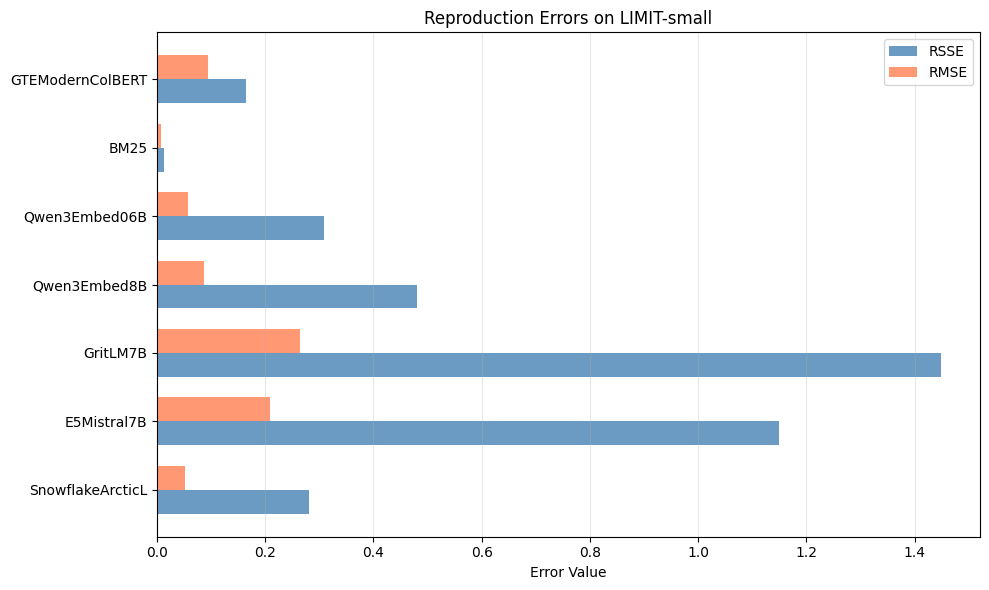

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your data - the ERROR values from the table
model_names = [
    "SnowflakeArcticL",
    "E5Mistral7B",
    "GritLM7B",
    "Qwen3Embed8B",
    "Qwen3Embed06B",
    "BM25",
    "GTEModernColBERT",
]

error_pairs = [
    errors(model_name, recalls_pred, recalls_from_paper)
    for model_name in model_names
]

rsse = [error[0] for error in error_pairs]
rmse = [error[1] for error in error_pairs]

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(model_names))
width = 0.35

ax.barh(y_pos - width / 2, rsse, width, label="RSSE", alpha=0.8, color="steelblue")
ax.barh(y_pos + width / 2, rmse, width, label="RMSE", alpha=0.8, color="coral")

ax.set_yticks(y_pos)
ax.set_yticklabels(model_names)
ax.set_xlabel("Error Value")
ax.set_title("Reproduction Errors on LIMIT-small")
ax.legend()
ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig("limit_small_benchmark_errors.pdf")


In [6]:
import matplotlib.pyplot as plt

def visualize(
    recalls_of: dict[str, dict[int, list[float]]],
    save_diagram: bool = False,
    saved_diagram_name: str = None
):
    mrl_model_names = {"SnowflakeArcticL", "Qwen3Embed8B", "Qwen3Embed06B"}
    dims_to_plot = [32, 512, 1024, 2048, 3072, 4096]
    recalls_to_plot = [0, 0.2, 0.4, 0.6, 0.8, 1]
    dims = [32, 64, 128, 256, 512, 768, 1024, 2048, 3072, 4096]
    top_ks = [2, 10, 20]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, k in enumerate(top_ks):
        axis = axes[i]
        axis.set_title(f"Recall@{k}")
        axis.set_xlabel("Dimension")
        if i == 0:
            axis.set_ylabel("Recall")
        axis.set_ylim(0, 1.05)
        axis.set_xticks(dims_to_plot)
        axis.set_xticklabels([str(d) for d in dims_to_plot])
        axis.set_yticks(recalls_to_plot)
        axis.set_yticklabels([str(r) for r in recalls_to_plot])

    extra_models = ["BM25", "GTEModernColBERT"]
    model_names = set(recalls_of) - set(extra_models)
    
    for model_name in model_names:
        model_recalls = recalls_of[model_name]
        for i, top_k in enumerate(model_recalls):
            axes[i].plot(
                dims, 
                model_recalls[top_k], 
                marker='*' if model_name in mrl_model_names else ".", 
                label=model_name
            )

    extra_model_colors = ["gray", "brown"]
    for model_name, color in zip(extra_models, extra_model_colors):
        model_recalls = recalls_of[model_name]
        for i, top_k in enumerate(model_recalls):
            axes[i].axhline(
                y=recalls_of[model_name][top_k][0],
                linestyle="--",
                linewidth=1.40,
                color=color,
                label=model_name
            )
    
    # set legend by removing duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(
        by_label.values(), 
        by_label.keys(), 
        loc='lower center', 
        ncol=4, 
        bbox_to_anchor=(0.5, -0.1)
    )
        
    plt.tight_layout()
    plt.show()
    if save_diagram:
        saved_diagram_name = saved_diagram_name or "recalls_diagram.pdf"
        fig.savefig(saved_diagram_name, bbox_inches='tight')

The previous analysis can be demostrated with the following plots, where the MRL supported models are marked with starts.

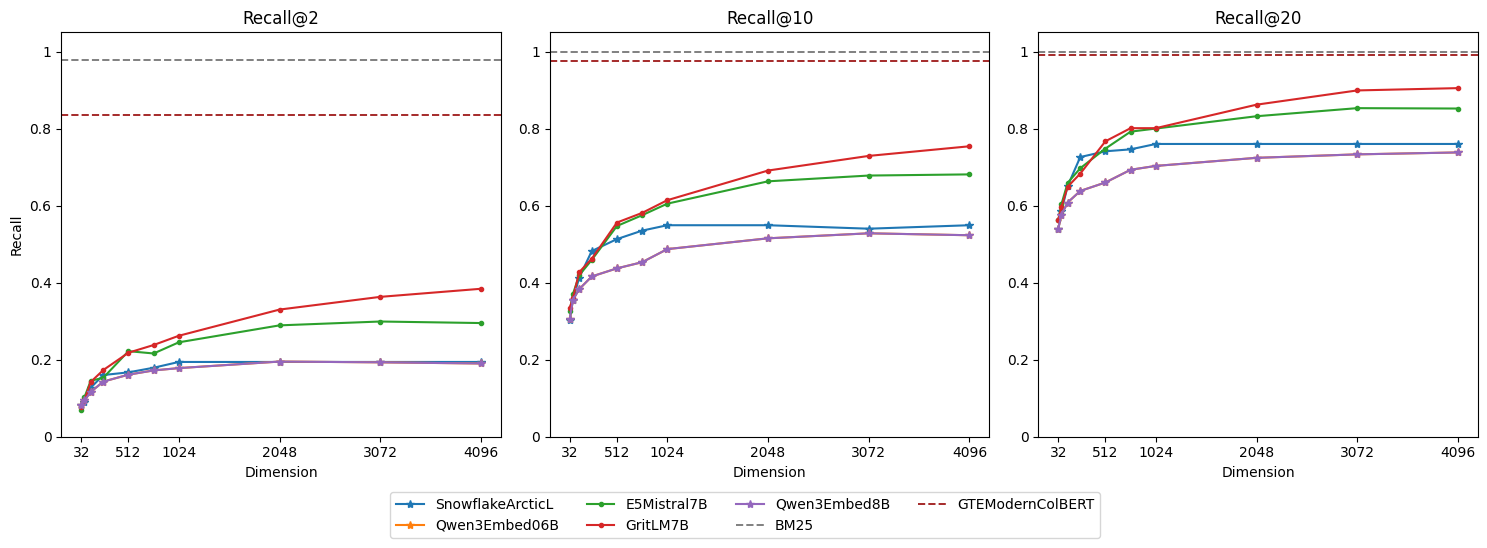

In [13]:
visualize(recalls_of=recalls_from_paper, save_diagram=True, saved_diagram_name="recalls_limit_small_expected.pdf")

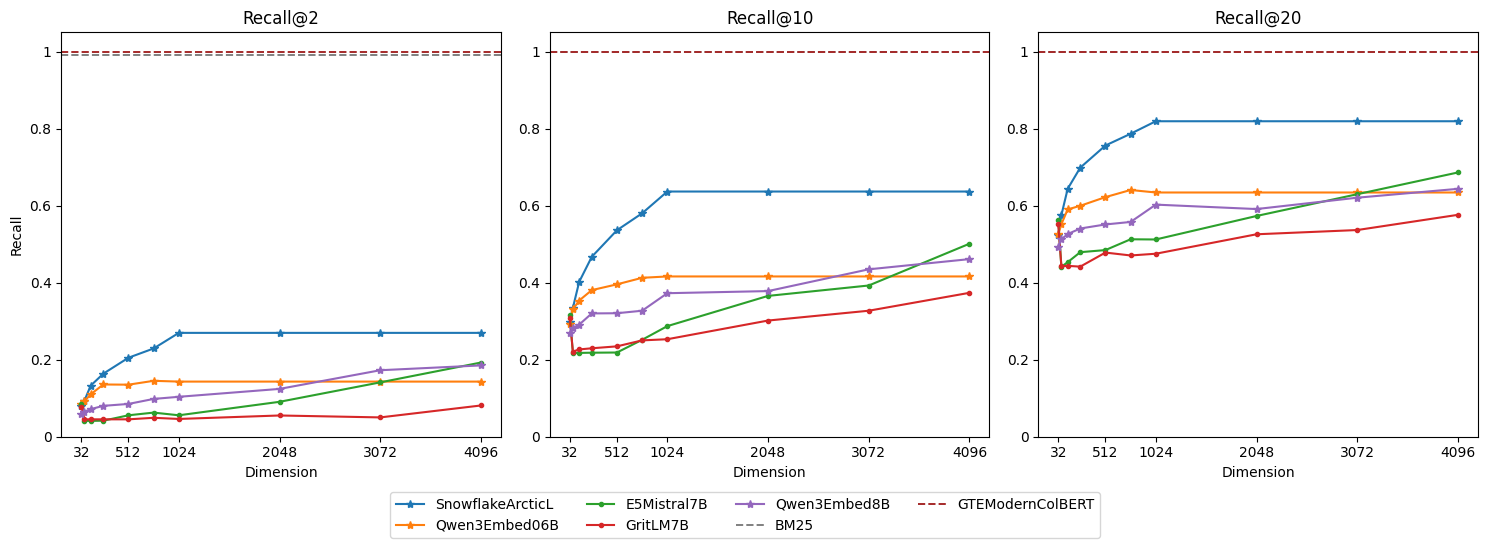

In [14]:
visualize(recalls_of=recalls_pred, save_diagram=True, saved_diagram_name="recalls_limit_small_predicted.pdf")

## Correlation with MTEB

We've seen that the retrieval task on LIMIT-small is hard in case of both the original and reproduced setup. 

So, in the next, we are interesed in the connection between the BEIR benchmark and recalls in case of the LIMIT-small dataset.

In [ ]:
!pip install faiss-cpu beir
!pip install transformers torch bitsandbytes accelerate

The source code bellow was inspired from https://colab.research.google.com/drive/1HfutiEhHMJLXiWGT8pcipxT5L2TpYEdt?usp=sharing#scrollTo=tyC5x24k9ipJ

In [ ]:
import pathlib, os
import shutil

from beir import util
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval import models
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES
from sentence_transformers import SentenceTransformer

# incject fais into beir manually, cuz it isn't designed properly...
import faiss
import beir.retrieval.search.dense.faiss_index as beir_faiss
beir_faiss.faiss = faiss

def benchmark(
    model_name: str, 
    dataset_name: str, 
    batch_size: int = 8, 
    device: str = "cuda",
    use_cache: bool = True
) -> float:
    url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset_name}.zip"
    out_dir = os.path.join(os.getcwd(), "datasets")
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
        os.makedirs(out_dir, exist_ok=True)
        
    data_path = util.download_and_unzip(url, out_dir)
    
    corpus, queries, qrels = GenericDataLoader(data_path).load(split="test")
    model = DRES(
        models.SentenceBERT(
            model_name,
            max_length=192,
            device=device
        ),
        batch_size=batch_size
    )
    
    retriever = EvaluateRetrieval(model, score_function="cos_sim")
    
    # results = retriever.retrieve(corpus, queries)
    results = retriever.encode_and_retrieve(
        corpus, 
        queries, 
        overwrite=not use_cache, 
        encode_output_path=f"./embeddings/{model_name.split('/')[-1]}"
    )
    
    ndcg, _map, recall, precision = retriever.evaluate(qrels, results, retriever.k_values)
    return ndcg, _map, recall, precision

We benchmark all the previously tested 5 models, on 2 out of 18 BEIR datasets due to the time constraints.

In [3]:
model_names = [
    "Qwen/Qwen3-Embedding-0.6B",
    "Snowflake/snowflake-arctic-embed-l",
    "gabor-hosu/e5-mistral-7b-instruct-bnb-4bit",
    "gabor-hosu/GritLM-7B-bnb-4bit",
    "gabor-hosu/Qwen3-Embedding-8B-bnb-4bit"
]

selected_beir_datasets = [
    ("scifact", 64),
    ("nfcorpus", 64)
]

In [ ]:
from pathlib import Path
import pickle

model_name = model_names[4]
dataset, batch_size = selected_beir_datasets[1]


results_path = Path("./results.pkl")

results = {}
if results_path.exists():
    with open(results_path, "rb") as file:
        results = pickle.load(file)

model_results = results.get(model_name)
if model_results is None:
    results[model_name] = {}
    model_results = results[model_name]

model_results |= {dataset: benchmark(model_name, dataset, batch_size)}

with open(results_path, "wb") as file:
    pickle.dump(results, file)

In [6]:
results

{'Qwen/Qwen3-Embedding-0.6B': {'scifact': ({'NDCG@1': 0.55333,
    'NDCG@3': 0.62051,
    'NDCG@5': 0.65882,
    'NDCG@10': 0.67899,
    'NDCG@100': 0.70516,
    'NDCG@1000': 0.71236},
   {'MAP@1': 0.52428,
    'MAP@3': 0.59535,
    'MAP@5': 0.62072,
    'MAP@10': 0.63069,
    'MAP@100': 0.63669,
    'MAP@1000': 0.63695},
   {'Recall@1': 0.52428,
    'Recall@3': 0.66406,
    'Recall@5': 0.75867,
    'Recall@10': 0.81778,
    'Recall@100': 0.93667,
    'Recall@1000': 0.99333},
   {'P@1': 0.55333,
    'P@3': 0.24556,
    'P@5': 0.17067,
    'P@10': 0.09333,
    'P@100': 0.01067,
    'P@1000': 0.00112}),
  'nfcorpus': ({'NDCG@1': 0.36842,
    'NDCG@3': 0.33918,
    'NDCG@5': 0.32204,
    'NDCG@10': 0.29695,
    'NDCG@100': 0.28185,
    'NDCG@1000': 0.37264},
   {'MAP@1': 0.03725,
    'MAP@3': 0.06513,
    'MAP@5': 0.08118,
    'MAP@10': 0.09736,
    'MAP@100': 0.12894,
    'MAP@1000': 0.1433},
   {'Recall@1': 0.03725,
    'Recall@3': 0.07764,
    'Recall@5': 0.11014,
    'Recall@10': 0.14

In [4]:
import pickle

with open("./results.pkl", "rb") as file:
    results = pickle.load(file)

In [5]:
import numpy as np

convert_model_name = {
    "e5-mistral-7b-instruct-bnb-4bit": "E5Mistral7B", 
    "Qwen3-Embedding-8B-bnb-4bit": "Qwen3Embed8B", 
    "GritLM-7B-bnb-4bit" : "GritLM7B", 
    "Qwen3-Embedding-0.6B": "Qwen3Embed06B", 
    "snowflake-arctic-embed-l": "SnowflakeArcticL"
}

beir_results = {
    convert_model_name[model.split("/")[-1]] : np.array(
        list(
            results[model][dataset][0]["NDCG@10"] 
            for dataset in results[model]
        )
    ).mean().item()
    for model in results
}

limit_small_results = {
    model_name: recalls_for_model(model_name)(top_k=20, dimension=4096)
    for model_name in convert_model_name.values()
}

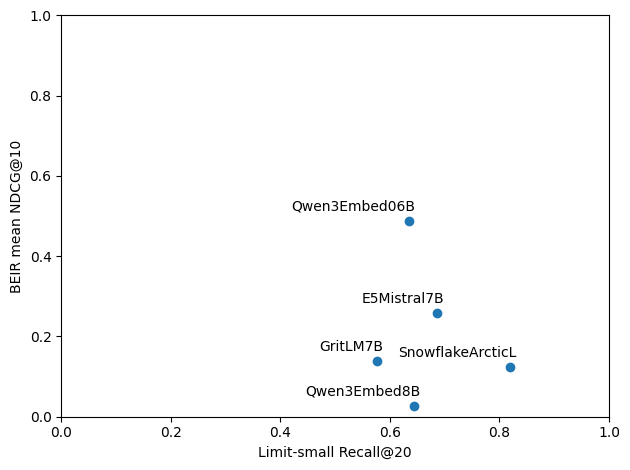

In [6]:
import matplotlib.pyplot as plt

plt.xlabel("Limit-small Recall@20")
plt.ylabel("BEIR mean NDCG@10")

x = [
    limit_small_results[model_name] 
    for model_name in limit_small_results
]

y = [
    beir_results[model_name] 
    for model_name in limit_small_results
]

plt.scatter(x, y) 

for model_name in limit_small_results:
    plt.annotate(
        model_name, 
        (limit_small_results[model_name], beir_results[model_name]), 
        xytext=(5, 5),  # offset in points
        textcoords='offset points',
        ha='right',
        va='bottom',
        fontsize=10
    )

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("limit_vs_beir_reprod.pdf", bbox_inches="tight")
plt.show()


Small correlation coefficient and high p-value $\implies$ weak, not statistically significant correlation.

In [7]:
from scipy.stats import pearsonr

limit_small = np.array(
    [    
        limit_small_results[model_name] 
        for model_name in limit_small_results
    ]
)

beir = np.array(
    [    
        beir_results[model_name] 
        for model_name in limit_small_results
    ]
)

corr, p_value = pearsonr(limit_small, beir)
print(f"Correlation coefficient: {corr}")
print(f"Corresponding p-value: {p_value}")

Correlation coefficient: -0.1627837429252869
Corresponding p-value: 0.7936563345664523


In [8]:
import pandas as pd

# original results from the paper

data = {
    "Model": [
        "SnowflakeArcticL",
        "Promptretriever",
        "E5Mistral7B",
        "GritLM7B",
        "GeminiEmbed",
        "Qwen3Embed8B"
    ],
    "BEIR": [55.22, 56.40, 57.07, 57.40, 62.65, 62.76],
    "Limit Recall@100": [3.3, 18.9, 8.3, 12.9, 10.0, 4.8]
}

df_paper = pd.DataFrame(data)

The original paper setup yields results consistent with the previous experiment.

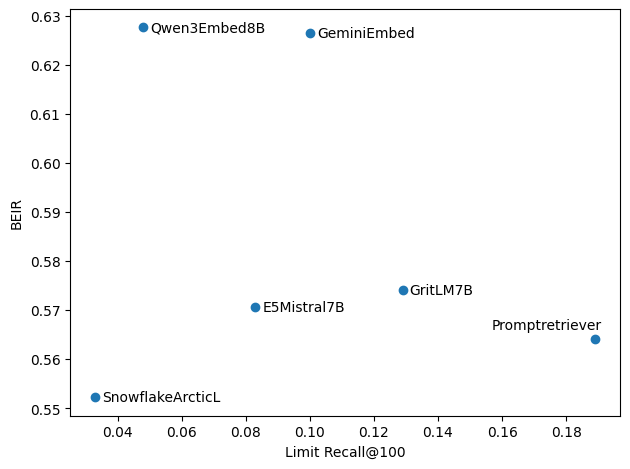

In [15]:
import matplotlib.pyplot as plt

plt.xlabel("Limit Recall@100")
plt.ylabel("BEIR")

x = df_paper["Limit Recall@100"].to_numpy() / 100
y = df_paper["BEIR"].to_numpy() / 100

plt.scatter(x, y) 

for i in range(len(df_paper)):
    model_name = df_paper["Model"][i]    
    ha, va = ("right", "bottom") if model_name == "Promptretriever" else ("left", "top")
    plt.annotate(
        model_name, 
        (x[i], y[i]), 
        xytext=(5, 5),  # offset in points
        textcoords="offset points",
        ha=ha,
        va=va,
        fontsize=10
    )

plt.tight_layout()
plt.savefig("limit_vs_beir.pdf", bbox_inches="tight")
plt.show()


In [23]:
corr, p_value = pearsonr(df_paper["BEIR"], df_paper["Limit Recall@100"])
print(f"Correlation coefficient: {corr}")
print(f"Corresponding p-value: {p_value}")

Correlation coefficient: -0.20876505546581756
Corresponding p-value: 0.6914017046813588
